In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [8]:
u = np.unique(grid_pts[:,0])

main_diags = [[(u[ii], u[ii]), (u[ii+1], u[ii+1])] for ii in [0,1,2]]
main_diags += [[(u[ii], u[3-ii]), (u[ii+1], u[3-(ii+1)])] for ii in [0,1,2]]

second_diags = [[(u[ii], u[ii+1]), (u[ii+1], u[ii+2])] for ii in [0,1]]
second_diags += [[(u[ii+1], u[ii]), (u[ii+2], u[ii+1])] for ii in [0,1]]

second_diags += [[(u[ii], u[3-(ii+1)]), (u[ii+1], u[3-(ii+2)])] for ii in [0,1]]
second_diags += [[(u[ii+1], u[3-ii]), (u[ii+2], u[3-(ii+1)])] for ii in [0,1]]

main_diags, second_diags

([[(0.1, 0.1), (1.7, 1.7)],
  [(1.7, 1.7), (3.3, 3.3)],
  [(3.3, 3.3), (4.9, 4.9)],
  [(0.1, 4.9), (1.7, 3.3)],
  [(1.7, 3.3), (3.3, 1.7)],
  [(3.3, 1.7), (4.9, 0.1)]],
 [[(0.1, 1.7), (1.7, 3.3)],
  [(1.7, 3.3), (3.3, 4.9)],
  [(1.7, 0.1), (3.3, 1.7)],
  [(3.3, 1.7), (4.9, 3.3)],
  [(0.1, 3.3), (1.7, 1.7)],
  [(1.7, 1.7), (3.3, 0.1)],
  [(1.7, 4.9), (3.3, 3.3)],
  [(3.3, 3.3), (4.9, 1.7)]])

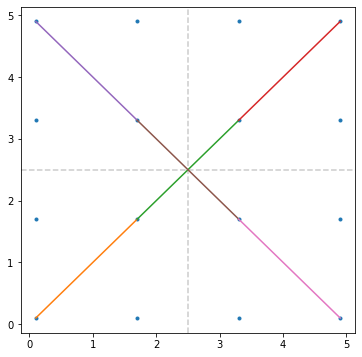

In [9]:
plt.figure(figsize=(6,6))
plt.plot(grid_pts[:,0], grid_pts[:,1], '.')
plt.axvline(2.5, color=[0.8, 0.8, 0.8],ls='--')
plt.axhline(2.5, color=[0.8, 0.8, 0.8],ls='--')
for ii in range(len(main_diags)):
    plt.plot([main_diags[ii][0][0], main_diags[ii][1][0]], 
         [main_diags[ii][0][1], main_diags[ii][1][1]], '-')

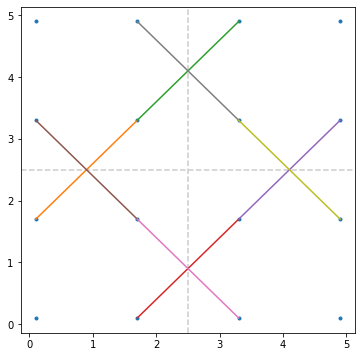

In [10]:
plt.figure(figsize=(6,6))
plt.plot(grid_pts[:,0], grid_pts[:,1], '.')
plt.axvline(2.5, color=[0.8, 0.8, 0.8],ls='--')
plt.axhline(2.5, color=[0.8, 0.8, 0.8],ls='--')
for ii in range(len(second_diags)):
    plt.plot([second_diags[ii][0][0], second_diags[ii][1][0]], 
         [second_diags[ii][0][1], second_diags[ii][1][1]], '-')

In [16]:
pt_labs[inds]

array([[4.9, 0.1],
       [4.9, 0.1],
       [3.3, 1.7],
       [3.3, 1.7],
       [4.9, 0.1],
       [4.9, 0.1],
       [3.3, 1.7],
       [4.9, 0.1],
       [3.3, 1.7],
       [4.9, 0.1],
       [4.9, 0.1],
       [3.3, 1.7],
       [3.3, 1.7],
       [4.9, 0.1],
       [3.3, 1.7],
       [4.9, 0.1],
       [3.3, 1.7],
       [4.9, 0.1],
       [4.9, 0.1],
       [4.9, 0.1],
       [4.9, 0.1],
       [3.3, 1.7],
       [3.3, 1.7],
       [3.3, 1.7],
       [4.9, 0.1],
       [4.9, 0.1],
       [4.9, 0.1],
       [3.3, 1.7],
       [3.3, 1.7],
       [3.3, 1.7],
       [4.9, 0.1],
       [4.9, 0.1],
       [4.9, 0.1]])

In [18]:
ind1 = np.where(np.all(grid_pts==coord1, axis=1))[0][0]
ind2 = np.where(np.all(grid_pts==coord2, axis=1))[0][0]
ind1, ind2

(9, 12)

In [19]:
grid_pts[9],grid_pts[12]

(array([3.3, 1.7]), array([4.9, 0.1]))

In [11]:
conf_maindiags = np.zeros((n_subjects, n_rois, n_tasks, len(main_diags)))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
  
        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T.round(2)

        is_main_grid = l['is_main_grid']==1
        
        for pi in range(len(main_diags)):
                
            coord1 = main_diags[pi][0]
            coord2 = main_diags[pi][1]
            
            
            # grab just the trials for the two points of interest here
            is1 = np.all(pt_labs==coord1, axis=1)
            is2 = np.all(pt_labs==coord2, axis=1)
        
            inds = is1 | is2
            
            # print([si, ti, sum(inds)])
            
            for ri in range(n_rois):

                prob = dec_withintask['probs_all'][si][ri][ti]
                
                # compare the probability that the classifier assigned to each of the labels
                # (it is possible the classifier predicted a label besides these two,
                # but it still assigns probability to these)
                ind1 = np.where(np.all(grid_pts==coord1, axis=1))[0][0]
                ind2 = np.where(np.all(grid_pts==coord2, axis=1))[0][0]
                p_categ1 = prob[:,ind1]
                p_categ2 = prob[:,ind2]
                
                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[is1] = p_categ1[is1] - p_categ2[is1]
                signedconf[is2] = p_categ2[is2] - p_categ1[is2]
                
                conf_maindiags[si,ri,ti,pi] = np.mean(signedconf[inds])
                

In [12]:
maindiag_names = ['%s vs %s'%(main_diags[ii][0], main_diags[ii][1]) for ii in range(len(main_diags))]
maindiag_names

['(0.1, 0.1) vs (1.7, 1.7)',
 '(1.7, 1.7) vs (3.3, 3.3)',
 '(3.3, 3.3) vs (4.9, 4.9)',
 '(0.1, 4.9) vs (1.7, 3.3)',
 '(1.7, 3.3) vs (3.3, 1.7)',
 '(3.3, 1.7) vs (4.9, 0.1)']

Text(0.5, 0.98, 'main diagonals')

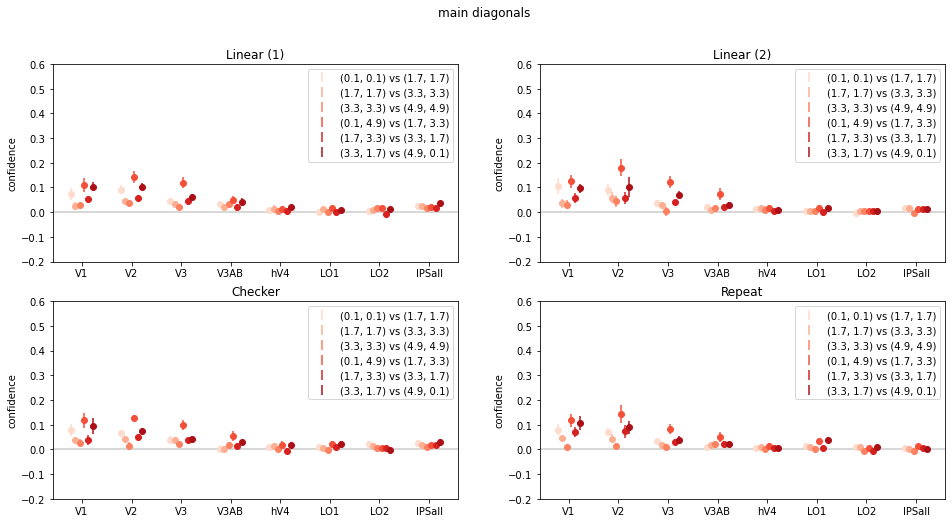

In [32]:
pair_colors = cm.Reds(np.linspace(0,1,8))[1:7,:]
pair_names = maindiag_names

x_jitter = np.linspace(-0.22, 0.22, len(main_diags))

plt.figure(figsize=(16,8))

for ti, task_name in enumerate(task_names):

    plt.subplot(2,2,ti+1)

    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for pi, pair_name in enumerate(pair_names):

        x_ticks = np.arange(n_rois) + x_jitter[pi]

        vals = conf_maindiags[:,:,ti,pi]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
        lh.append(h)

    plt.ylim([-0.2, 0.6])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    plt.legend(lh,pair_names)

    plt.title(task_names[ti])

plt.suptitle('main diagonals')


In [33]:
conf_seconddiags = np.zeros((n_subjects, n_rois, n_tasks, len(second_diags)))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
  
        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T.round(2)

        is_main_grid = l['is_main_grid']==1
        
        for pi in range(len(second_diags)):
                
            coord1 = second_diags[pi][0]
            coord2 = second_diags[pi][1]
            
            
            # grab just the trials for the two points of interest here
            is1 = np.all(pt_labs==coord1, axis=1)
            is2 = np.all(pt_labs==coord2, axis=1)
            
            inds = is1 | is2
            
            # print([si, ti, sum(inds)])
            
            for ri in range(n_rois):

                prob = dec_withintask['probs_all'][si][ri][ti]
                
                # compare the probability that the classifier assigned to each of the labels
                # (it is possible the classifier predicted a label besides these two,
                # but it still assigns probability to these)
                ind1 = np.where(np.all(grid_pts==coord1, axis=1))[0][0]
                ind2 = np.where(np.all(grid_pts==coord2, axis=1))[0][0]
                p_categ1 = prob[:,ind1]
                p_categ2 = prob[:,ind2]
                
                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[is1] = p_categ1[is1] - p_categ2[is1]
                signedconf[is2] = p_categ2[is2] - p_categ1[is2]
                
                conf_seconddiags[si,ri,ti,pi] = np.mean(signedconf[inds])
                

In [34]:
seconddiag_names = ['%s vs %s'%(second_diags[ii][0], second_diags[ii][1]) for ii in range(len(second_diags))]
seconddiag_names

['(0.1, 1.7) vs (1.7, 3.3)',
 '(1.7, 3.3) vs (3.3, 4.9)',
 '(1.7, 0.1) vs (3.3, 1.7)',
 '(3.3, 1.7) vs (4.9, 3.3)',
 '(0.1, 3.3) vs (1.7, 1.7)',
 '(1.7, 1.7) vs (3.3, 0.1)',
 '(1.7, 4.9) vs (3.3, 3.3)',
 '(3.3, 3.3) vs (4.9, 1.7)']

Text(0.5, 0.98, 'secondary diagonals')

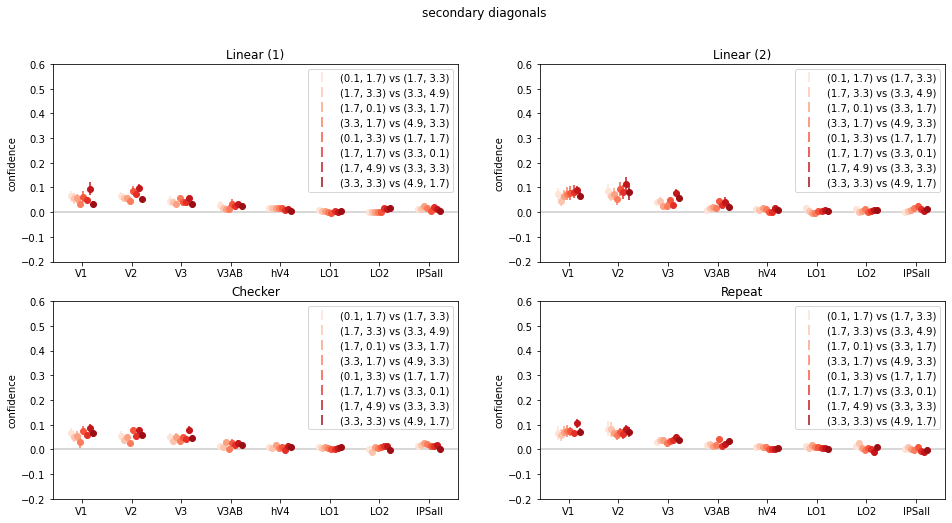

In [35]:
pair_colors = cm.Reds(np.linspace(0,1,10))[1:9,:]
pair_names = seconddiag_names

x_jitter = np.linspace(-0.22, 0.22, len(second_diags))

plt.figure(figsize=(16,8))

for ti, task_name in enumerate(task_names):

    plt.subplot(2,2,ti+1)

    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for pi, pair_name in enumerate(pair_names):

        x_ticks = np.arange(n_rois) + x_jitter[pi]

        vals = conf_seconddiags[:,:,ti,pi]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
        lh.append(h)

    plt.ylim([-0.2, 0.6])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    plt.legend(lh,pair_names)

    plt.title(task_names[ti])

plt.suptitle('secondary diagonals')


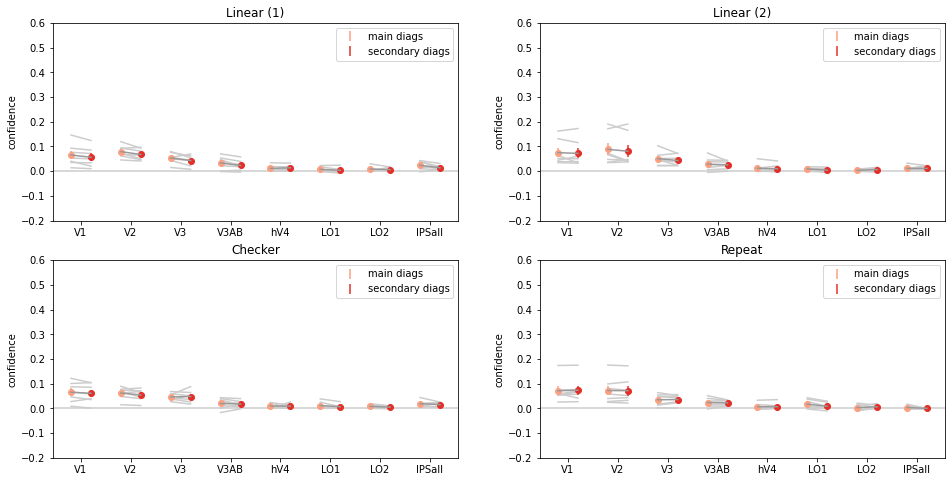

In [38]:
cvals = np.concatenate([np.mean(conf_maindiags, axis=3, keepdims=True), \
                      np.mean(conf_seconddiags, axis=3, keepdims=True)], axis=3)

pair_colors = cm.Reds(np.linspace(0,1,4))[1:3,:]
pair_names = ['main diags','secondary diags']

x_jitter = np.linspace(-0.2, 0.2, 2)

plt.figure(figsize=(16,8))

for ti, task_name in enumerate(task_names):

    plt.subplot(2,2,ti+1)

    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for pi, pair_name in enumerate(pair_names):

        x_ticks = np.arange(n_rois) + x_jitter[pi]

        vals = cvals[:,:,ti,pi]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
       
        plt.plot(ri+x_jitter, np.mean(cvals[:,ri,ti,:], axis=0), color=[0.6,0.6, 0.6])
        
        plt.plot(ri+x_jitter, cvals[:,ri,ti,:].T, color=[0.8, 0.8, 0.8], zorder=-10)
        
    plt.ylim([-0.2, 0.6])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    plt.legend(lh,pair_names)

    plt.title(task_names[ti])

# plt.suptitle('secondary diagonals')
